The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [6]:
# 1) Put Colab's scientific stack back to versions it expects
!pip install -q "numpy==2.0.2" "pandas==2.2.2" "matplotlib==3.10.0" "matplotlib-inline>=0.1.7" "jedi>=0.16"

# 2) Install d2l **without** its stale dependency pins
!pip install -q --no-deps d2l==1.0.3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
d2l 1.0.3 requires jupyter==1.0.0, which is not installed.
d2l 1.0.3 requires matplotlib==3.7.2, but you have matplotlib 3.10.0 which is incompatible.
d2l 1.0.3 requires matplotlib-inline==0.1.6, but you have matplotlib-inline 0.1.7 which is incompatible.
d2l 1.0.3 requires numpy==1.23.5, but you have numpy 2.0.2 which is incompatible.
d2l 1.0.3 requires pandas==2.0.3, but you have pandas 2.2.2 which is incompatible.
d2l 1.0.3 requires requests==2.31.0, but you have requests 2.32.4 which is incompatible.
d2l

In [7]:
import numpy, pandas, matplotlib, d2l
print("NumPy:", numpy.__version__)
print("pandas:", pandas.__version__)
print("matplotlib:", matplotlib.__version__)
print("d2l imported ✔")


NumPy: 2.0.2
pandas: 2.2.2
matplotlib: 3.10.0
d2l imported ✔


PyTorch: 2.8.0+cu126


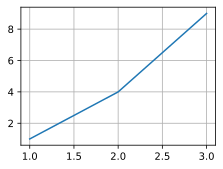

In [8]:
try:
    from d2l import torch as d2l
    import torch
    print("PyTorch:", torch.__version__)
    d2l.set_figsize()
    d2l.plot([1,2,3], [1,4,9])  # quick smoke test
except ModuleNotFoundError as e:
    print(e)
    # Install PyTorch (GPU build commonly used in Colab)
    # Then re-run the cell
    # %pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


# Dropout
:label:`sec_dropout`


Let's think briefly about what we
expect from a good predictive model.
We want it to peform well on unseen data.
Classical generalization theory
suggests that to close the gap between
train and test performance,
we should aim for a simple model.
Simplicity can come in the form
of a small number of dimensions.
We explored this when discussing the
monomial basis functions of linear models
in :numref:`sec_generalization_basics`.
Additionally, as we saw when discussing weight decay
($\ell_2$ regularization) in :numref:`sec_weight_decay`,
the (inverse) norm of the parameters also
represents a useful measure of simplicity.
Another useful notion of simplicity is smoothness,
i.e., that the function should not be sensitive
to small changes to its inputs.
For instance, when we classify images,
we would expect that adding some random noise
to the pixels should be mostly harmless.

:citet:`Bishop.1995` formalized
this idea when he proved that training with input noise
is equivalent to Tikhonov regularization.
This work drew a clear mathematical connection
between the requirement that a function be smooth (and thus simple),
and the requirement that it be resilient
to perturbations in the input.

Then, :citet:`Srivastava.Hinton.Krizhevsky.ea.2014`
developed a clever idea for how to apply Bishop's idea
to the internal layers of a network, too.
Their idea, called *dropout*, involves
injecting noise while computing
each internal layer during forward propagation,
and it has become a standard technique
for training neural networks.
The method is called *dropout* because we literally
*drop out* some neurons during training.
Throughout training, on each iteration,
standard dropout consists of zeroing out
some fraction of the nodes in each layer
before calculating the subsequent layer.

To be clear, we are imposing
our own narrative with the link to Bishop.
The original paper on dropout
offers intuition through a surprising
analogy to sexual reproduction.
The authors argue that neural network overfitting
is characterized by a state in which
each layer relies on a specific
pattern of activations in the previous layer,
calling this condition *co-adaptation*.
Dropout, they claim, breaks up co-adaptation
just as sexual reproduction is argued to
break up co-adapted genes.
While such an justification of this theory is certainly up for debate,
the dropout technique itself has proved enduring,
and various forms of dropout are implemented
in most deep learning libraries.


The key challenge is how to inject this noise.
One idea is to inject it in an *unbiased* manner
so that the expected value of each layer---while fixing
the others---equals the value it would have taken absent noise.
In Bishop's work, he added Gaussian noise
to the inputs to a linear model.
At each training iteration, he added noise
sampled from a distribution with mean zero
$\epsilon \sim \mathcal{N}(0,\sigma^2)$ to the input $\mathbf{x}$,
yielding a perturbed point $\mathbf{x}' = \mathbf{x} + \epsilon$.
In expectation, $E[\mathbf{x}'] = \mathbf{x}$.

In standard dropout regularization,
one zeros out some fraction of the nodes in each layer
and then *debiases* each layer by normalizing
by the fraction of nodes that were retained (not dropped out).
In other words,
with *dropout probability* $p$,
each intermediate activation $h$ is replaced by
a random variable $h'$ as follows:

$$
\begin{aligned}
h' =
\begin{cases}
    0 & \textrm{ with probability } p \\
    \frac{h}{1-p} & \textrm{ otherwise}
\end{cases}
\end{aligned}
$$

By design, the expectation remains unchanged, i.e., $E[h'] = h$.


In [9]:
import torch
from torch import nn
from d2l import torch as d2l

## Dropout in Practice

Recall the MLP with a hidden layer and five hidden units
from :numref:`fig_mlp`.
When we apply dropout to a hidden layer,
zeroing out each hidden unit with probability $p$,
the result can be viewed as a network
containing only a subset of the original neurons.
In :numref:`fig_dropout2`, $h_2$ and $h_5$ are removed.
Consequently, the calculation of the outputs
no longer depends on $h_2$ or $h_5$
and their respective gradient also vanishes
when performing backpropagation.
In this way, the calculation of the output layer
cannot be overly dependent on any
one element of $h_1, \ldots, h_5$.

![MLP before and after dropout.](http://d2l.ai/_images/dropout2.svg)
:label:`fig_dropout2`

Typically, we disable dropout at test time.
Given a trained model and a new example,
we do not drop out any nodes
and thus do not need to normalize.
However, there are some exceptions:
some researchers use dropout at test time as a heuristic
for estimating the *uncertainty* of neural network predictions:
if the predictions agree across many different dropout outputs,
then we might say that the network is more confident.

## Implementation from Scratch

To implement the dropout function for a single layer,
we must draw as many samples
from a Bernoulli (binary) random variable
as our layer has dimensions,
where the random variable takes value $1$ (keep)
with probability $1-p$ and $0$ (drop) with probability $p$.
One easy way to implement this is to first draw samples
from the uniform distribution $U[0, 1]$.
Then we can keep those nodes for which the corresponding
sample is greater than $p$, dropping the rest.

In the following code, we (**implement a `dropout_layer` function
that drops out the elements in the tensor input `X`
with probability `dropout`**),
rescaling the remainder as described above:
dividing the survivors by `1.0-dropout`.


In [10]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1: return torch.zeros_like(X)
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

We can [**test out the `dropout_layer` function on a few examples**].
In the following lines of code,
we pass our input `X` through the dropout operation,
with probabilities 0, 0.5, and 1, respectively.


In [18]:
X = torch.arange(16, dtype = torch.float32).reshape((2, 8))
print('dropout_p = 0:', dropout_layer(X, 0))
print('dropout_p = 0.5:', dropout_layer(X, 0.5))
print('dropout_p = 1:', dropout_layer(X, 1))

dropout_p = 0: tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
dropout_p = 0.5: tensor([[ 0.,  2.,  4.,  6.,  0., 10.,  0.,  0.],
        [16., 18., 20., 22.,  0., 26., 28., 30.]])
dropout_p = 1: tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


### Defining the Model

The model below applies dropout to the output
of each hidden layer (following the activation function).
We can set dropout probabilities for each layer separately.
A common choice is to set
a lower dropout probability closer to the input layer.
We ensure that dropout is only active during training.


In [19]:
class DropoutMLPScratch(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.lin1 = nn.LazyLinear(num_hiddens_1)
        self.lin2 = nn.LazyLinear(num_hiddens_2)
        self.lin3 = nn.LazyLinear(num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((X.shape[0], -1))))
        if self.training:
            H1 = dropout_layer(H1, self.dropout_1)
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = dropout_layer(H2, self.dropout_2)
        return self.lin3(H2)

### [**Training**]

The following is similar to the training of MLPs described previously.


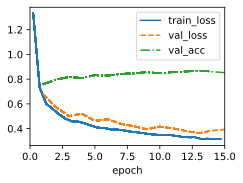

In [28]:
hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0, 'dropout_2':0, 'lr':0.1}
model = DropoutMLPScratch(**hparams)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=15)
trainer.fit(model, data)

## [**Concise Implementation**]

With high-level APIs, all we need to do is add a `Dropout` layer
after each fully connected layer,
passing in the dropout probability
as the only argument to its constructor.
During training, the `Dropout` layer will randomly
drop out outputs of the previous layer
(or equivalently, the inputs to the subsequent layer)
according to the specified dropout probability.
When not in training mode,
the `Dropout` layer simply passes the data through during testing.


In [21]:
class DropoutMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(), nn.LazyLinear(num_hiddens_1), nn.ReLU(),
            nn.Dropout(dropout_1), nn.LazyLinear(num_hiddens_2), nn.ReLU(),
            nn.Dropout(dropout_2), nn.LazyLinear(num_outputs))

Next, we [**train the model**].


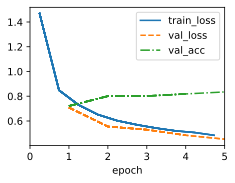

In [22]:
model = DropoutMLP(**hparams)
trainer.fit(model, data)

In [25]:
hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}

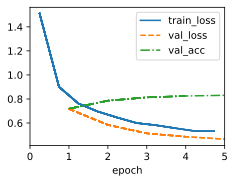

In [26]:
model = DropoutMLP(**hparams)
trainer.fit(model, data)

## Summary

Beyond controlling the number of dimensions and the size of the weight vector, dropout is yet another tool for avoiding overfitting. Often tools are used jointly.
Note that dropout is
used only during training:
it replaces an activation $h$ with a random variable with expected value $h$.


## Exercises

1. What happens if you change the dropout probabilities for the first and second layers? In particular, what happens if you switch the ones for both layers? Design an experiment to answer these questions, describe your results quantitatively, and summarize the qualitative takeaways.
1. Increase the number of epochs and compare the results obtained when using dropout with those when not using it.
1. What is the variance of the activations in each hidden layer when dropout is and is not applied? Draw a plot to show how this quantity evolves over time for both models.
1. Why is dropout not typically used at test time?
1. Using the model in this section as an example, compare the effects of using dropout and weight decay. What happens when dropout and weight decay are used at the same time? Are the results additive? Are there diminished returns (or worse)? Do they cancel each other out?
1. What happens if we apply dropout to the individual weights of the weight matrix rather than the activations?
1. Invent another technique for injecting random noise at each layer that is different from the standard dropout technique. Can you develop a method that outperforms dropout on the Fashion-MNIST dataset (for a fixed architecture)?


Dropout


Intro

We want our models to perform well on unseen data, also known as generalization. Classical learning theory tells us that if we want this, we should have a simple model. Simplicity can come in the form of low dimensionality. This was seen previously in the monomial degree inputs of linear models (how you can express ridge 2 and higher functions in a single layer, but this exponentially increases in input parameter size due to having to enumerate through all combinations). Looking at weight decay, the inverse norm of the parameters also is a useful measure of simplicity. Simple models are smoother, and thus inherently less sensitive to noise. As such, we can expect that adding a small amount of noise shouldn't meaningfully affect the accuracy of the models predictions.

This idea was formulated by (Bishop, 1995), where he proved that training with input noise is equivalent to tikhonov regularization. This work drew the connection between a model being smooth (thus simple), and the requirement that it be resilient to input noise.

(Srivastava et al, 2014) applied this idea through the method dropout, where each internal layer is injected with noise during the forward pass. This is done through choosing a percentage of nodes to "dropout", or zeroing a fraction of them.

The intuition provided by the paper was that this was like reducing co-adaptation in genes. The authors believed that overfit was due to layers needing a specific pattern of inputs in the previous layer. Dropout is supposed to break this co-adaptation, just like sexual reproduction is argued to do for co-adapted genes (because layers are forced to output the same desired output with the pattern being disrupted, representations become more resilient and thus general).

The manner used for noise injection is also different from Bishops approach, who injected gaussian noise. Given the mean at zero, this means that the E[x] remains the same.

However, given that dropout was supposed to completely "remove neurons from the gene pool", they went about this with the discrete manner, where with dropout probability p, each output h is scaled to be h/(1-p), which also preserved E[h'] = h



Dropout in Practice

Looking back at the neural netwrok in section mlp, with 4 input neurons, 5 hidden neurons and 3 output neurons. If we remove hidden neurons 2 and 5 with dropout, what happens is that all weights flowing in and out of them disappear. So, they do not contribute to the values of the forward pass, and are not used for the gradient either. What this means is that the network cannot be overly reliant on a singular neuron, as if that one isn't active then the network would be much more likely fail to get the correct output. So, dropout reduces the dependency on a singular neuron. Dropout typically is turned off at test time, although some researchers keep it on to see if predictions remain consistent across many different dropout outputs, which would essentially indicate how confident the network is.


Summary

Beyond controlling the number of dimensions and the size of weight vectors, dropout offers another method to avoid overfitting. These methods, along with others, are often used jointly. Dropout is only used during training, and replaces each activation h, with another activation that has expected value h.



Exercises

1. What happens if you change the dropout probabilities for the first and second layers? In particular, what happens if you switch the ones for both layers? Design an experiment to answer these questions, describe your results quantitatively, and summarize the qualitative takeaways.

Having a higher dropout value on the first hidden layer compared to the second (such as 0.7 0.3) is worse than the inverse. The reason for this is pretty obvious, you are essentially "starving" the later layer of activations. For overall, I noticed that 0.5 is the value for most equal "subnetwork expression", so having a dropout value of 0.5 should have the strongest regularization effect.


2. Increase the number of epochs and compare the results obtained when using dropout with those when not using it.

Training with dropout make the test loss oscillate less, which lines up with the purpose of dropout as a regularization method, showing that it prevented overfitting better than when no dropout was used.


3. What is the variance of the activations in each hidden layer when dropout is and is not applied? Draw a plot to show how this quantity evolves over time for both models.

The variance of activations within each hidden layer is zero when dropout is not applied. This is because it is deterministic whether each neuron activates or not, as it is purely based off of the value. Given that dropout is a bernoulli random variable, the variance becomes p/(1-p) * h ^ 2, so the variance increases exponentially the higher the dropout value. This is exactly the desired behaviour, as forcing the model to deal with variance results in it becoming more robust and makes it generalizes better.


4. Why is dropout not typically used at test time?

Dropout is typically not used at test time because it makes results non deterministic. Additionally, dropout acts as a temporary reduction in network expressitivity (essentially makes the neural network exist as many subnetworks), whichis no longer necessary, because you are not learning anymore, and can use the full model capacity to deal with samples.


[Discussions](https://discuss.d2l.ai/t/101)
